In [25]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [26]:
game.display() # 게임화면 출력

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [27]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.makeMove('l')
game.makeMove('l')
game.makeMove('u')
game.makeMove('u')
game.display()

array([['+', '-', ' ', ' '],
       ['P', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [28]:
# 보상환경= [목적지(+)도착: 10, 구덩이(-)에 빠짐: -10, 그외나머지: -1]
game.reward() # 보상출력 

-1

In [6]:
game.board.render_np() #게임 상태를 출력함 (0, 플레이어), (1, 목표), (2, 구덩이), (3, 벽)

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

(4,4,4)텐서를 (64,)로 reshape하여 input데이터로 씀

In [7]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(64, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

c:\Users\dodo7\miniconda3\envs\lesa3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [31]:
epochs = 1000
losses = [] #손실값을 담는 리스트 history그리는데 사용됨
for i in range(epochs): #에폭수=게임횟수
    game = Gridworld(size=4, mode='static') #게임 생성
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 # 게임 state에 0~0.1사이에 난수를 더해줌(실제환경을 표방한 약간의 잡음추가가 아니다 overfitting과 0이 relu에서 미분이 되지않는다는점에서이다)
    state1 = torch.from_numpy(state_).float() #Numpy배열 pytorch 텐서로 변환
    status = 1 # 게임이 진행중이면 1 아니면 0으로 수정됨
    while(status == 1): # 하나의 게임이 완료될때까지 돌아가는 루프
        qval = model(state1) # 모델 예측 시작 모든동작의 Q가치 예측 (4, )
        qval_ = qval.data.numpy()
        if random.random() < epsilon: # 엡실론 확률로 무작위 액션을 취한다
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_) # 최적의 액션 선택
        
        action = action_set[action_] # Gridworld 게임이 이해하는 동작 문자로 변환
        game.makeMove(action) # 실제로 동작 수행
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 # 앞서 수행한 동작의 결과를 바탕으로 state2의 상태를 가져온다
        state2 = torch.from_numpy(state2_).float() #Numpy배열 pytorch 텐서로 변환
        reward = game.reward() # 액션후 보상을받는다
        with torch.no_grad(): # 역전파 대상에서 제외
            newQ = model(state2.reshape(1,64)) # 다음 상태 모든동작의 Q가치 예측
        maxQ = torch.max(newQ) # 액션중 최대 Q가치를 가져온다
        if reward == -1: # 목표 Q가치를 계산한다
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] # 실제로 동작을 실힝했었던 액션의 예측 Q가치만 따로 저장
        loss = loss_fn(X, Y) # 오차 계산 해당코드에선 (mse loss)
        print(f'epoch {i} loss {loss.item()}') # 에폭, 로스
        # clear_output(wait=True)
        optimizer.zero_grad() # 역전파 시작 
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: # 구덩이에 빠지거나, 목적지에 도달시 게임은 종료
            status = 0
    if epsilon > 0.1: # 한 에피소드가 끝날때마다 엡실론은 감소(시간이 갈수록 더 느리게 감소)
        epsilon -= (1/epochs)

epoch 0 loss 0.29822587966918945
epoch 0 loss 0.01637454703450203
epoch 0 loss 0.3707325756549835
epoch 0 loss 0.0031282335985451937
epoch 0 loss 0.5043797492980957
epoch 0 loss 0.21797500550746918
epoch 0 loss 0.022687384858727455
epoch 0 loss 0.004650149494409561
epoch 0 loss 0.676575243473053
epoch 0 loss 0.015040543861687183
epoch 0 loss 0.14305512607097626
epoch 0 loss 0.3573802411556244
epoch 0 loss 1.2355409860610962
epoch 0 loss 0.48608461022377014
epoch 0 loss 0.06464660167694092
epoch 0 loss 0.1630619615316391
epoch 0 loss 0.4801503121852875
epoch 0 loss 0.8679422736167908
epoch 0 loss 0.156711146235466
epoch 0 loss 0.5235269665718079
epoch 0 loss 0.6317777633666992
epoch 0 loss 1.15132474899292
epoch 0 loss 0.9563296437263489
epoch 0 loss 1.027207374572754
epoch 0 loss 0.043299440294504166
epoch 0 loss 0.5072817206382751
epoch 0 loss 0.6172661781311035
epoch 0 loss 2.1648671627044678
epoch 0 loss 0.12371323257684708
epoch 0 loss 0.6462525129318237
epoch 0 loss 0.480436146259

Text(0, 0.5, 'Loss')

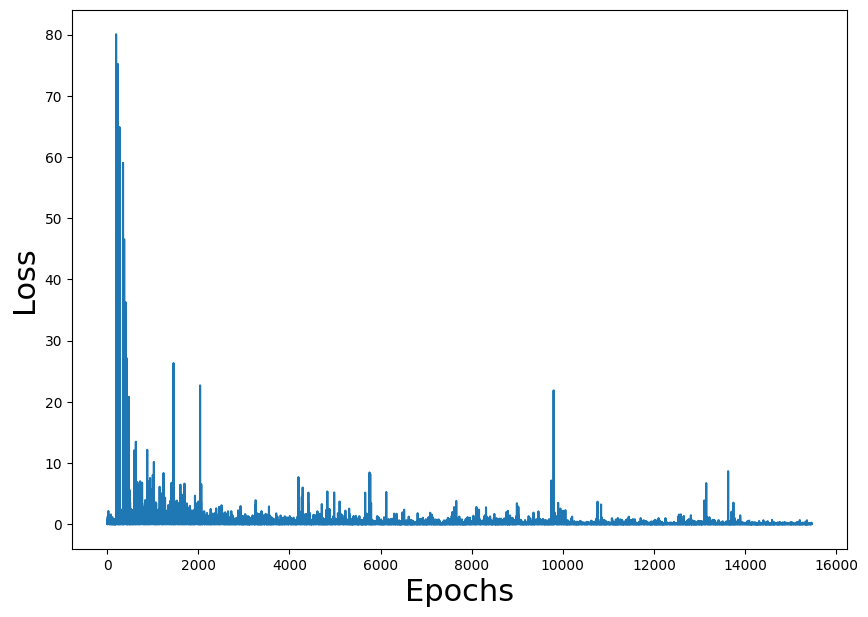

In [32]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [37]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): 
        qval = model(state) # 예측
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) # 가장 가치가 높은 액션 선택
        action = action_set[action_] 
        if display:
            print('Move #: %s; Taking action: %s' % (i, action)) 
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 # 움직임 이후의 다음 state불러오기
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1: # 게임의 종료
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False # 처음보는 문법인데.. if를 기준으로 True면 왼쪽실행 False면 오른쪽실행한다 else는 필수인듯
    return win

In [38]:
test_model(model)

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[['+' '-' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True


궁금증1. 같은 게임에서 배치가 바뀌어도 학습없이 잘 할수있을까?

나의 예상: 잘할수있을것같다

In [41]:
test_model(model,mode='random')

Initial State:
[['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' ' ' 'P']
 [' ' ' ' ' ' 'W']]
Move #: 0; Taking action: l
[['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' 'P' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 1; Taking action: l
[['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Game LOST. Reward: -10


False

잘하지못했다 한번도 학습되어본적이 없는 input이 들어와서 전혀 제대로된 예측을 하고있지않는것같다

mode='random'으로 설정하고 학습을 진행하더라도 loss가 수렴하지않아 의미있는 학습결과를 보여주지 못한다고 했다(그렇군...)
해당 학습 모델은 플레이를 말그대로 "암기"했을뿐 전혀 일반화 하지못하고 있는뜻과 같다
다행인건 딥마인드도 이런문제를 겪었고 그들은 해결책을 찾았다는것이다